In [1]:
import torch
from torch.autograd import Variable
from torch.distributions import Normal
from functorch import vmap
import matplotlib.pylab as plt
import numpy as np
import scipy.stats as ss
import pickle
import random

In [2]:
import sys
sys.path.insert(0,'../vp_class/')

In [3]:
from class_tou_v4_updated import tOU, tou_gradient

This code applies variational inference based on time-dependent OU processes to the observations drawn from the double well system SDE, as defined below. Note that we have chosen observational noise, i.e. variance of Gaussian noise and SDE variance to be 0.64 and 0.01 repectively.

m(t) = $\alpha$t + $m_{0}$

1. Simulate prior process, i.e. double-well system whose SDE is given by

$dX_{t} = 4X_{t}(1-X^{2}_{t})dt + \sigma dW_{t}$

In [4]:
with open('../EX03_DW_Model', 'rb') as f:
    prior = pickle.load(f)
    likelihood = pickle.load(f)

In [5]:
def prior_drift (s, x_s):
    return 4 * x_s * (1 - (x_s ** 2))

In [6]:
true_sde_pts, true_sde_trj = prior[0], prior[1]
obs, obs_time = likelihood[0], likelihood[1]
sde_sigma = 0.8 # Variance is higher than the original example
obs_sigma = 0.1

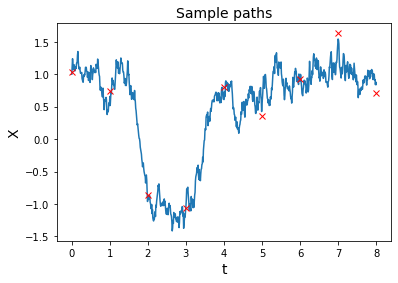

In [7]:
# Plot paths
plt.plot(true_sde_pts,true_sde_trj)
plt.plot(obs_time, obs, "rx")
plt.xlabel("t", fontsize=14)
plt.ylabel("X", fontsize=14)
plt.title("Sample paths", fontsize=14)
plt.show()


Variational inference: KL

2. Implement Variational inference based on $\textbf{time-inhomogeneous}$ OU process with SDE:

$$dX_{t} = [-\frac{a}{at+b}X_{t} + (ct+d)] dt + \sigma^{2} dW_{t}$$

$$\mathbb{E}_{P^{Z}}[\log\exp{\frac{dP^{X}}{dP^{Z}}(Z)] = \frac{1}{2}\mathbb{E}_{P^{Z}}[\int_{t_{0}}}^{t_{1}}|\frac{4Z_{t}(1-Z^{2}_{t}) + \frac{a}{at+b}Z_{t} - (ct+d)}{\sigma}|^{2}dt]$$


In [8]:
class ELBO:
    """
        ELBO with
            variational process (q): time-inhomogeneous OU process
            prior process (p): double-well system
            
        This class computes: - KL(q|p) + NLL(y|z)  where z \sim q
    """
    def __init__(self, ou):
        self.ou = ou
        
        self.alpha = ou.alpha
        self.beta = ou.beta
        self.r = ou.r
        
        self.sigma = ou.sigma
        

    def KL(self, prior_drift):
        """
            This function requires the function corresponding to prior drift function
        """
        # Save parameter specification from ou class
        alpha, beta, r, sigma = self.alpha, self.beta, self.r, self.sigma
        m0 = self.ou.trj[:, 0].reshape(-1, 1)
        
        def B(s, beta):
            return (s+1) ** beta
        
        def m(s):
            return alpha * (B(s, beta) - 1) + m0
            
        def m_(s):
            return alpha * beta * B(s, beta-1)
        
        t = self.ou.pts - self.ou.pts[:, 0].reshape(-1, 1)
        
        # Evaluate the drift function of the approximating processes
        g_of_x = -r * (self.ou.trj - m(t)) + m_(t)
        
        # Evaluate the drift function of the model (prior process)
        f_of_x = prior_drift(t, self.ou.trj)
        
        # Compute the term inside the KL divergence
        
        F_of_X = abs(((f_of_x - g_of_x) / sigma) ** 2)
        
        dt = t[:, -1] - t[:, 0]
        
        return 0.5 * torch.sum(F_of_X, axis=1).reshape(-1, 1) / F_of_X.shape[1] * dt.reshape(-1, 1)
            
    def log_prob(self, obs, obs_sigma):
        """
            Compute the log-likelihood
            likelihood function is normal density N(obs, var)
            obs.shape = D * 1 (D: # of sample)
        """
        def log_pdf(obs, z, obs_sigma):
            return ss.norm.logpdf(obs, loc=z, scale=obs_sigma)
            
        return torch.from_numpy(log_pdf(obs, self.ou.trj[:, -1].reshape(-1, 1), obs_sigma))


**Variational inference: a piece-wise approximation**

In [9]:
import tqdm as tq

In [10]:
def score_estimate(s0, sK, current_pars, sigma, obs, obs_sigma, init_dist, M):
    """
        Returns stochastic estimates of the gradient of the ELBO with respect to parameters including
            alpha, r, beta
        
        M: # of Monte Carlo samples
        
    """
    assert obs.shape[0] == 1, "observation must be 1-d torch.array"
    
    # Number of time points drawn between s0 and sK
    K = 200
    
    # Reshape every parameter into (M,1) torch.array
    SIGMA = sigma.repeat(M, 1)
    OBS = obs.repeat(M, 1)
    # Simulate sample path
    # Note that z0 = m0
    
    pars = {key:val.repeat(M, 1) for key,val in current_pars.items()}
    
    vi = tOU(t0=s0, t1=sK, parameters = pars, sde_sigma=SIGMA, init_dist = init_dist, timegrid = 'False', dN=K)

    # Compute the ELBO 
    elbo = ELBO(vi)
    score_func = tou_gradient(vi.pts, vi.trj, pars, SIGMA, init_dist)
    f_of_x = -elbo.log_prob(OBS, obs_sigma) + elbo.KL(prior_drift)
    
    # Variational objective
    vi_obj = {'NELBO': torch.nanmean(f_of_x).item(), 'KL': torch.nanmean(elbo.KL(prior_drift)).item(), 'NLL': -1 * torch.nanmean(elbo.log_prob(OBS, obs_sigma)).item() }
    
    return {key: torch.nanmean(f_of_x * score_func[key]) for key in pars.keys()}, vi_obj

Sanity check

Examine the distribution of score function estimates of the gradient of each parameter.

In [ ]:
dist = Normal(loc=0, scale=1.)
t0 = torch.tensor(1.)
t1 = torch.tensor(2.)
sigma = torch.tensor([1.]).reshape(-1, 1)

In [ ]:
parameters = {'alpha': torch.tensor([0.15]).reshape(-1, 1), \
             'beta': torch.tensor([0.8]).reshape(-1, 1), \
             'r': torch.tensor([3.05]).reshape(-1, 1)}

In [ ]:
init_pts = torch.tensor([1.0]).reshape(-1, 1)

In [ ]:
tou = tOU(t0, t1, parameters, sigma, init_dist=init_pts)

In [ ]:
estimates = {key:[] for key in parameters.keys()}

for i in range(500):
    grads, elbo_estimate = score_estimate(t0, t1, parameters, sigma, obs[0], obs_sigma, init_pts, 2000)
    for key in grads.keys():
        estimates[key].append(grads[key].item())

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
par_names = list(estimates.keys())

for j, ax in enumerate(axs.ravel()):
    if j < 3:
        ax.hist(estimates[par_names[j]], bins=30)
        ax.axvline(np.mean(estimates[par_names[j]]), linestyle='dashed', color='black')
        ax.set_title(par_names[j])
        ax.set_xlabel("Gradient estimate")
        ax.set_ylabel("Frequency")

In [11]:
def AdamStep(g_t, m_t, v_t, beta_1, beta_2, t):
    """
        compute bias corrected moments
    """
#     print(g_t, m_t, v_t, beta_1, beta_2, t)
    m_t_next = beta_1 * m_t + (1 - beta_1) * g_t
    v_t_next = beta_2 * v_t + (1 - beta_2) * g_t ** 2
    
    m_t_corrected = m_t_next / (1 - (beta_1 ** t))
    v_t_corrected = v_t_next / (1 - (beta_2 ** t))
    
#     print(m_t_corrected, v_t_corrected)
    return m_t_corrected, v_t_corrected

def AdamGrad(current_pars, current_grad, prev_moments,  beta_1, beta_2, learning_rate = 0.01, smooth_term = 1e-8):
    assert type(current_pars) == type(current_grad) == type(prev_moments) == dict, "Current_grad must be a dict"
    """
        Perform one-step Adam gradient descent
    """
    new_pars = {}
    for key in current_pars.keys():
        if key == 'r':
            m_t, v_t = AdamStep(current_grad[key], prev_moments[key][0], prev_moments[key][1], beta_1, beta_2, prev_moments['t'])
            new_pars[key] = current_pars[key] - learning_rate / np.sqrt(v_t + smooth_term) * m_t
            value = new_pars[key]
            while value <= 0:
                value = current_pars[key] - learning_rate / np.sqrt(v_t + smooth_term) * m_t
                learning_rate *= 0.5
            new_pars[key] = value
            
        else:
            m_t, v_t = AdamStep(current_grad[key], prev_moments[key][0], prev_moments[key][1], beta_1, beta_2, prev_moments['t'])
            new_pars[key] = current_pars[key] - learning_rate / np.sqrt(v_t + smooth_term) * m_t
        
        # Save moments for next iteration    
        prev_moments[key][0] = m_t
        prev_moments[key][1] = v_t
    
    prev_moments['t'] += 1
    
    return new_pars
    
    
    

In [12]:
def E_of_X ( init_pts, pts, parameters ):
    """
        Return mean of the process (which has analytical expression)
    """

    alpha = parameters['alpha']
    beta = parameters['beta']
    r = parameters['r']
    
    return alpha * ((pts + 1) ** beta - 1) + init_pts
    

In [13]:
def V_of_X (pts, parameters, prev_parameters, sde_sigma):
    """
        Return standard deviation of the process (from its analytical expression)
    """
    r = parameters['r']
    
    if prev_parameters == False:
        # for the first time step, we compute the variance given the initial point is fixed
        return torch.sqrt(0.5 * sde_sigma * sde_sigma / r * (1 - torch.exp(-2 * r * pts)))
    
    else:
        # for subsequent time steps, we compute the variance given the initial state is a random variable from approximate posterior
        prev_r = prev_parameters['r']

        v_0 = 0.5 * sde_sigma * sde_sigma / prev_r

        return torch.sqrt(0.5 * sde_sigma * sde_sigma / r * (1 - torch.exp(-2 * r * pts) * (2*r/(sde_sigma * sde_sigma) * v_0 - 1 )))


In [14]:
def get_PostMoment(t0, tT, parameters, prev_parameters, sde_sigma, init_pts, vN):
    """
        Returns approximate posterior's mean and standard deviation
    """
    # Get time-grid between s0 and sK
    
    t = torch.linspace(0, (tT-t0).item(), vN+2)[1:].reshape(-1, 1)
    mean = E_of_X(init_pts, t, parameters)
    std = V_of_X(t, parameters, prev_parameters, sde_sigma)

    return t.flatten(), mean.flatten(), std.flatten()

**To be added: 1. parameter update history, 2. elbo, KL, and loglikelihood estimate, 3. randomizing initial state**

In [15]:
def Optimize(sde_sigma, obs, obs_time, obs_sigma, M, IT, vN, learning_rate,  init_state = "Random", Optimizer="Adam", beta_1 = 0.9, beta_2 = 0.999, smooth_term = 1e-8, FIX_PAR=False):
    """
        vN: # of time points between in each obs interval on which mean of the approximate posterior process will be evaluated
    """
    assert type(sde_sigma) == torch.Tensor, "SDE sigma must be a torch.Tensor"
    assert type(obs) == torch.Tensor, "obs must be a torch.Tensor"

    N_of_Pars = 3
    
    T = obs.shape[0]
    
    v_N = T * (vN+1) - vN
    
    VP_PTS = np.zeros(v_N)
    VP_MEAN = np.zeros(v_N)
    VP_STD = np.zeros(v_N)
    
    # Intialize the state at the first observation
    init_mean = obs[0]
    VP_MEAN[0] = init_mean
    
    past_grad = {'alpha':np.zeros((T-1, IT)), 'beta':np.zeros((T-1, IT)), 'r':np.zeros((T-1, IT))}
    past_pars = {'alpha':np.zeros((T-1, IT)), 'beta':np.zeros((T-1, IT)), 'r': np.zeros((T-1, IT))}
    past_vi = {'NELBO':np.zeros((T-1, IT)), 'KL':np.zeros((T-1, IT)), 'NLL':np.zeros((T-1, IT))}
    
    for t in tq.tqdm(range(1, T)):
        s0 = obs_time[t-1]
        sK = obs_time[t]
        
        if init_state == 'Random':
            if t == 1:
                init_dist = init_mean
            else:
                init_dist = Normal(loc=init_mean, scale= init_std)
        else:
            init_dist = init_mean
            
        # Initialize a set of parameters
        current_pars = {key:torch.randn(1) for key in past_grad.keys() if key != 'r'}
        current_pars['r'] = torch.tensor(5.)

        if Optimizer == "Adam":
            prev_moments = {key:[0, 0] for key in current_pars.keys()}
            prev_moments['t'] = 1
            
#    past_grad = {key:torch.tensor([0.01]) for key in current_pars.keys()}
    
        for i in range(IT):
            if (i % (IT/2) == 0):
                for key in current_pars.keys():
                    print(str(i) +"/ " + key + ": "+ str(current_pars[key].item()) )
                    
            # Take gradient descent algorithm based on AdaGrad
            
            # Obtain stochastic estimate of the gradients based on score function estimator
            current_grad, vi_objective = score_estimate(s0, sK, current_pars, sde_sigma, obs[t], obs_sigma, init_dist, M)
            
            for key in vi_objective.keys():
                past_vi[key][t-1, i] = vi_objective[key]
            
            print(str(i) +"/ " + "Negative ELBO: "+ str(vi_objective['NELBO']))
            
#             if vi_objective['ELBO'] < 20:
#                 break
            # Take one gradient step based on the AdaGrad
            if Optimizer == "Adam":
                current_pars = AdamGrad(current_pars, current_grad, prev_moments, beta_1, beta_2, learning_rate, smooth_term)
                
            else:
                current_pars = Grad_Descent(current_pars, current_grad, learning_rate)
            
            if FIX_PAR != False:
                for key in FIX_PAR.keys():
                    current_pars[key] = FIX_PAR[key]
            
            for key in current_grad.keys():
                past_grad[key][t-1, i] = current_grad[key].item()
                past_pars[key][t-1, i] = current_pars[key].item()
            
        if t == 1:
            prev_pars = False
            
        # Obtain moments of approximating processes (note that their forms are tractable)
        vp_pts, vp_mean, vp_std = get_PostMoment(s0, sK, current_pars, prev_pars, sde_sigma, init_mean, vN)
        VP_PTS[(vN+1)*(t-1)+1:(vN+1)*t+1] = obs_time[t-1] + vp_pts
        VP_MEAN[(vN+1)*(t-1)+1:(vN+1)*t+1] = vp_mean
        VP_STD[(vN+1)*(t-1)+1:(vN+1)*t+1] = vp_std
        
        init_mean = vp_mean[-1]
        init_std = vp_std[-1]
        
        if t > 1:
            prev_pars = current_pars
        
        print("observation: " + str(obs[t].item()) + " variational mean: " + str(init_mean.item()))
    return VP_PTS, VP_MEAN, VP_STD, past_pars, past_grad, past_vi

Examine the convergence of parameters / model fit across different initializations/number_of_iterations

In [16]:
# FIX_PAR = {'a':torch.tensor([1.])}

In [17]:
output = []
for it in tq.tqdm([50]):
    vp__pts, vp__mean, vp__std, vp__pars, vp__grads, vp__obj = Optimize(torch.tensor([sde_sigma]),\
                                                      obs, obs_time, obs_sigma, \
                                                      init_state="Random", M=1500, \
#                                                       FIX_PAR = FIX_PAR,
                                                               \
                                                      IT=it, vN=150, learning_rate=0.05, \
                                                      Optimizer="Adam", beta_1 = 0.35, beta_2 = 0.01)
    output.append([vp__pts, vp__mean, vp__std, vp__pars, vp__grads])

  0%|                                                                                                                                                                                                                                                                   | 0/8 [00:00<?, ?it/s]

0/ alpha: 0.8889733552932739
0/ beta: -0.17731375992298126
0/ r: 5.0
0/ Negative ELBO: 5.133336193983756
1/ Negative ELBO: 4.445881338091777
2/ Negative ELBO: 3.3468233232156352
3/ Negative ELBO: 2.698385589838066
4/ Negative ELBO: 2.6263486064685186
5/ Negative ELBO: 3.0969313539764043
6/ Negative ELBO: 2.7641211810396467
7/ Negative ELBO: 2.499402074059127
8/ Negative ELBO: 2.528155385747509
9/ Negative ELBO: 2.410836173382667
10/ Negative ELBO: 2.4218749741180394
11/ Negative ELBO: 2.5110656381640903
12/ Negative ELBO: 3.980807416094241
13/ Negative ELBO: 3.6052767788985123
14/ Negative ELBO: 2.9047933195362887
15/ Negative ELBO: 2.268849097709174
16/ Negative ELBO: 2.1882895702056984
17/ Negative ELBO: 2.160605679186138
18/ Negative ELBO: 2.335530859074483
19/ Negative ELBO: 2.2647754859991966
20/ Negative ELBO: 1.9831656258950643
21/ Negative ELBO: 2.224618185965854
22/ Negative ELBO: 2.4575448605533334
23/ Negative ELBO: 2.0301217514550127
24/ Negative ELBO: 1.9654922316490173
25


 12%|███████████████████████████████▍                                                                                                                                                                                                                           | 1/8 [00:04<00:29,  4.26s/it]

49/ Negative ELBO: 1.5022276994128247
observation: 0.7418740051633642 variational mean: 0.7524457861406557
0/ alpha: 1.1814370155334473
0/ beta: -0.3203640282154083
0/ r: 5.0
0/ Negative ELBO: 100.65016571867035
1/ Negative ELBO: 96.96500081586552
2/ Negative ELBO: 87.45881362531101
3/ Negative ELBO: 82.2739365266508
4/ Negative ELBO: 76.24850785381084
5/ Negative ELBO: 70.16164066729701
6/ Negative ELBO: 64.72382426576048
7/ Negative ELBO: 59.094051795412284
8/ Negative ELBO: 54.68550305178954
9/ Negative ELBO: 49.852670124197644
10/ Negative ELBO: 45.543030511639486
11/ Negative ELBO: 40.39230390728005
12/ Negative ELBO: 36.09145912274808
13/ Negative ELBO: 32.03445310128452
14/ Negative ELBO: 28.11447316082497
15/ Negative ELBO: 24.66563322459498
16/ Negative ELBO: 20.502196422243028
17/ Negative ELBO: 18.262076675400596
18/ Negative ELBO: 15.780275514827997
19/ Negative ELBO: 13.893216619650543
20/ Negative ELBO: 10.980316259444677
21/ Negative ELBO: 9.884872951129978
22/ Negative 


 25%|██████████████████████████████████████████████████████████████▊                                                                                                                                                                                            | 2/8 [00:08<00:25,  4.26s/it]

47/ Negative ELBO: 10.27106915304523
48/ Negative ELBO: 9.9935352229865
49/ Negative ELBO: 8.93823467062301
observation: -0.8564873337841266 variational mean: -0.8183837532997131
0/ alpha: 0.3671114146709442
0/ beta: -1.6373414993286133
0/ r: 5.0
0/ Negative ELBO: 12.525325194953078
1/ Negative ELBO: 10.725090432725901
2/ Negative ELBO: 10.138462805264151
3/ Negative ELBO: 8.720150852035962
4/ Negative ELBO: 10.270955117762462
5/ Negative ELBO: 9.572252822792386
6/ Negative ELBO: 9.076881207580414
7/ Negative ELBO: 8.657712791874797
8/ Negative ELBO: 8.502618106267262
9/ Negative ELBO: 8.296011347370866
10/ Negative ELBO: 8.923867197645283
11/ Negative ELBO: 8.245969476035558
12/ Negative ELBO: 8.216930817144549
13/ Negative ELBO: 7.906308981620153
14/ Negative ELBO: 8.365848066091788
15/ Negative ELBO: 7.679390921370375
16/ Negative ELBO: 8.456983547491731
17/ Negative ELBO: 7.6477479388774885
18/ Negative ELBO: 7.953177780777961
19/ Negative ELBO: 7.570425730183193
20/ Negative ELBO:


 38%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                            | 3/8 [00:12<00:21,  4.27s/it]

48/ Negative ELBO: 6.926556224070602
49/ Negative ELBO: 6.801288238001549
observation: -1.0673319792395932 variational mean: -1.0002964735031128
0/ alpha: -0.48978307843208313
0/ beta: -0.20050908625125885
0/ r: 5.0
0/ Negative ELBO: 159.37297747597472
1/ Negative ELBO: 156.9756499815627
2/ Negative ELBO: 151.37233961180337
3/ Negative ELBO: 145.70374920253536
4/ Negative ELBO: 140.48364063856746
5/ Negative ELBO: 137.9359234356213
6/ Negative ELBO: 130.02761856273727
7/ Negative ELBO: 123.08464957914588
8/ Negative ELBO: 117.3424559771684
9/ Negative ELBO: 109.97275740354314
10/ Negative ELBO: 105.64696266481667
11/ Negative ELBO: 98.72891309556171
12/ Negative ELBO: 95.79507038395872
13/ Negative ELBO: 91.71638742512725
14/ Negative ELBO: 83.83351471327371
15/ Negative ELBO: 79.55500034482513
16/ Negative ELBO: 73.60858678930282
17/ Negative ELBO: 67.166709369227
18/ Negative ELBO: 62.23487674364212
19/ Negative ELBO: 57.07453804823165
20/ Negative ELBO: 52.475633531942776
21/ Negati


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                             | 4/8 [00:17<00:17,  4.30s/it]

49/ Negative ELBO: 10.131489408450685
observation: 0.7995340035602375 variational mean: 0.8521020412445068
0/ alpha: -0.735787570476532
0/ beta: -1.1273561716079712
0/ r: 5.0
0/ Negative ELBO: 61.009046204972854
1/ Negative ELBO: 59.7232712061696
2/ Negative ELBO: 49.86266097888209
3/ Negative ELBO: 44.220907506981234
4/ Negative ELBO: 39.46936584642881
5/ Negative ELBO: 35.84660534680178
6/ Negative ELBO: 31.65367567333039
7/ Negative ELBO: 28.70811261545107
8/ Negative ELBO: 26.898213830156145
9/ Negative ELBO: 23.405470641387094
10/ Negative ELBO: 22.539554614757087
11/ Negative ELBO: 21.403914699412336
12/ Negative ELBO: 19.979260612710053
13/ Negative ELBO: 18.15505871514448
14/ Negative ELBO: 18.122526131146635
15/ Negative ELBO: 17.178304129756974
16/ Negative ELBO: 17.770016679880104
17/ Negative ELBO: 15.486014625148382
18/ Negative ELBO: 14.785439078315006
19/ Negative ELBO: 15.304921962391353
20/ Negative ELBO: 13.627269468146118
21/ Negative ELBO: 13.3199737266237
22/ Negat


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                              | 5/8 [00:21<00:13,  4.34s/it]

47/ Negative ELBO: 7.0777519818224714
48/ Negative ELBO: 7.554164312773452
49/ Negative ELBO: 7.106455636416671
observation: 0.3540452486520327 variational mean: 0.31761568784713745
0/ alpha: -2.2279958724975586
0/ beta: -0.14087069034576416
0/ r: 5.0
0/ Negative ELBO: 13.971443190381153
1/ Negative ELBO: 11.069474077648554
2/ Negative ELBO: 8.67209869670299
3/ Negative ELBO: 6.576046642013644
4/ Negative ELBO: 5.565280208215126
5/ Negative ELBO: 13.98144805719891
6/ Negative ELBO: 10.790063086814708
7/ Negative ELBO: 9.22784468471344
8/ Negative ELBO: 6.213777910862517
9/ Negative ELBO: 5.915691081323819
10/ Negative ELBO: 6.003023354232183
11/ Negative ELBO: 6.034640382114208
12/ Negative ELBO: 5.2139400149322634
13/ Negative ELBO: 6.941310805884233
14/ Negative ELBO: 5.658729895860522
15/ Negative ELBO: 5.492166893992959
16/ Negative ELBO: 6.679330088600013
17/ Negative ELBO: 5.888277942451384
18/ Negative ELBO: 5.4921086225792415
19/ Negative ELBO: 6.987890374790882
20/ Negative EL


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 6/8 [00:25<00:08,  4.34s/it]

48/ Negative ELBO: 5.200534070970779
49/ Negative ELBO: 5.286951919507428
observation: 0.9328201877376548 variational mean: 0.9290863275527954
0/ alpha: -0.017938435077667236
0/ beta: -0.058962631970644
0/ r: 5.0
0/ Negative ELBO: 32.29351386573836
1/ Negative ELBO: 32.384112294566314
2/ Negative ELBO: 31.716336064610573
3/ Negative ELBO: 31.763808654682496
4/ Negative ELBO: 29.67111312284045
5/ Negative ELBO: 29.987318609117832
6/ Negative ELBO: 28.329676001707785
7/ Negative ELBO: 28.605591748529182
8/ Negative ELBO: 28.7912977609584
9/ Negative ELBO: 27.0191355433255
10/ Negative ELBO: 25.642815736241115
11/ Negative ELBO: 25.211109601507264
12/ Negative ELBO: 25.647085580919295
13/ Negative ELBO: 27.05055008287015
14/ Negative ELBO: 31.427481150109088
15/ Negative ELBO: 28.41613083673433
16/ Negative ELBO: 26.430495324296597
17/ Negative ELBO: 25.615121670470604
18/ Negative ELBO: 26.24381057799662
19/ Negative ELBO: 25.432104308582
20/ Negative ELBO: 25.20221581248706
21/ Negative


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 7/8 [00:30<00:04,  4.36s/it]

48/ Negative ELBO: 24.50196820713777
49/ Negative ELBO: 23.969610633972625
observation: 1.6311081388826472 variational mean: 1.1720025539398193
0/ alpha: 2.6965813636779785
0/ beta: -0.9789218306541443
0/ r: 5.0
0/ Negative ELBO: 46.9894046590783
1/ Negative ELBO: 40.41799447177525
2/ Negative ELBO: 33.63687246871411
3/ Negative ELBO: 28.258572828534156
4/ Negative ELBO: 23.22089010765224
5/ Negative ELBO: 18.9840124820673
6/ Negative ELBO: 15.284971878875428
7/ Negative ELBO: 11.952838478470333
8/ Negative ELBO: 9.803339072213886
9/ Negative ELBO: 8.360746562093272
10/ Negative ELBO: 9.266224771714013
11/ Negative ELBO: 8.503375522808264
12/ Negative ELBO: 7.510469722659534
13/ Negative ELBO: 7.629356216580907
14/ Negative ELBO: 8.242031674934704
15/ Negative ELBO: 7.486183637361801
16/ Negative ELBO: 7.391483221562189
17/ Negative ELBO: 7.866170419042154
18/ Negative ELBO: 7.7870633145806165
19/ Negative ELBO: 7.463767369444699
20/ Negative ELBO: 7.490441127001204
21/ Negative ELBO: 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:34<00:00, 34.64s/it]

49/ Negative ELBO: 7.935349650917919
observation: 0.708966867981579 variational mean: 0.7324869632720947


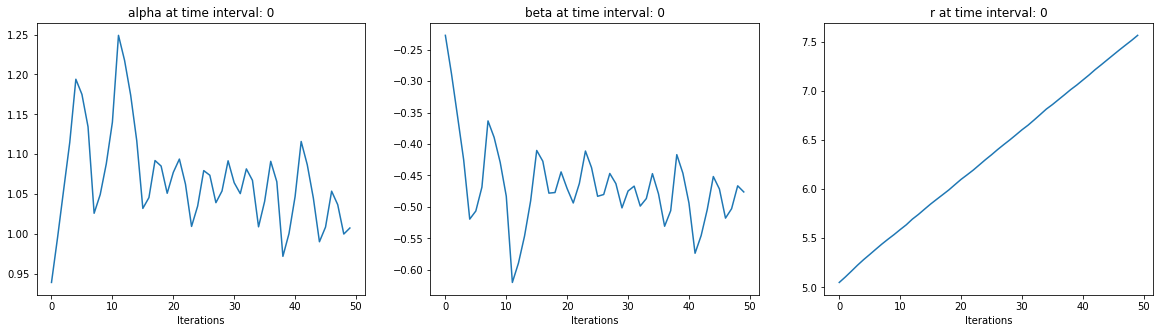

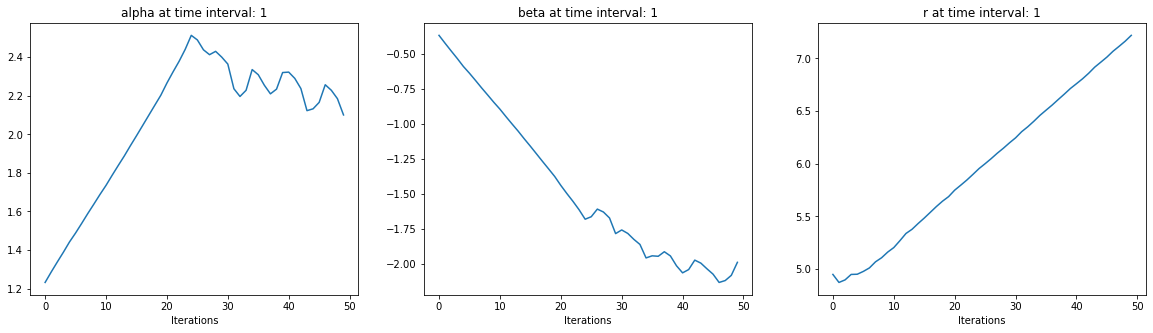

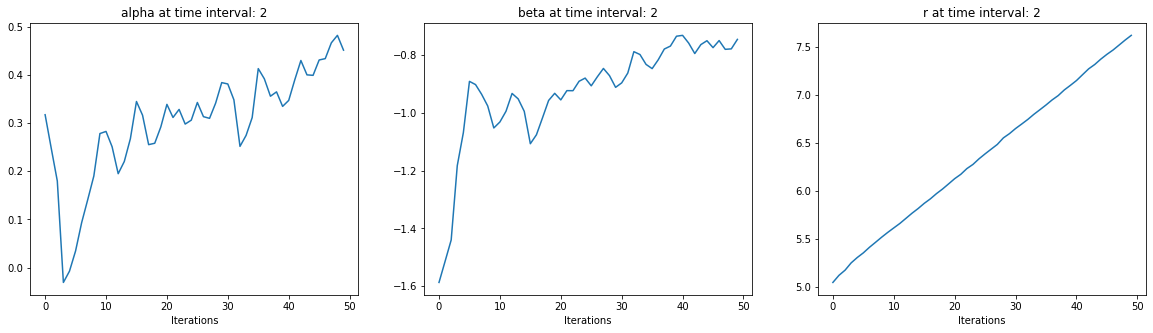

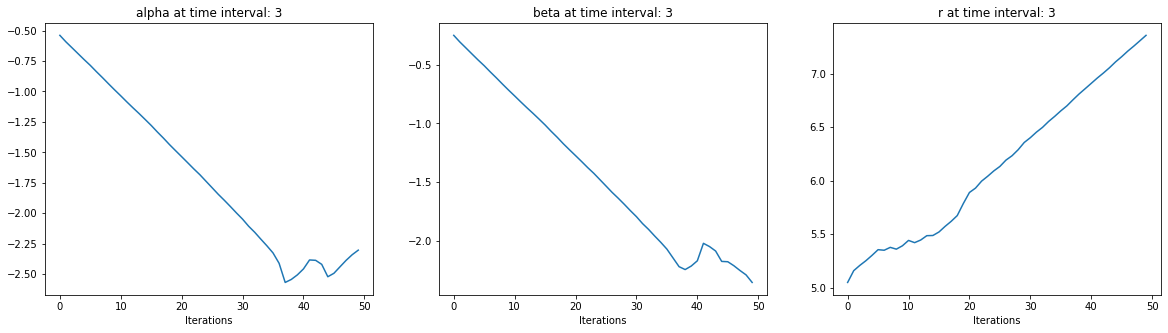

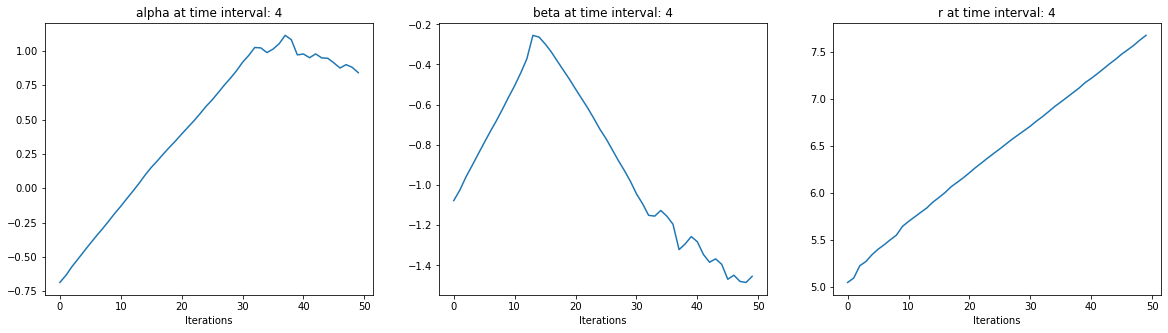

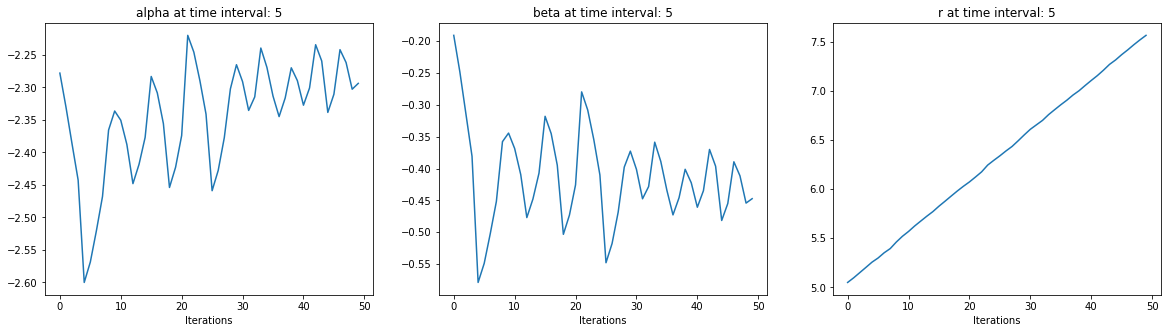

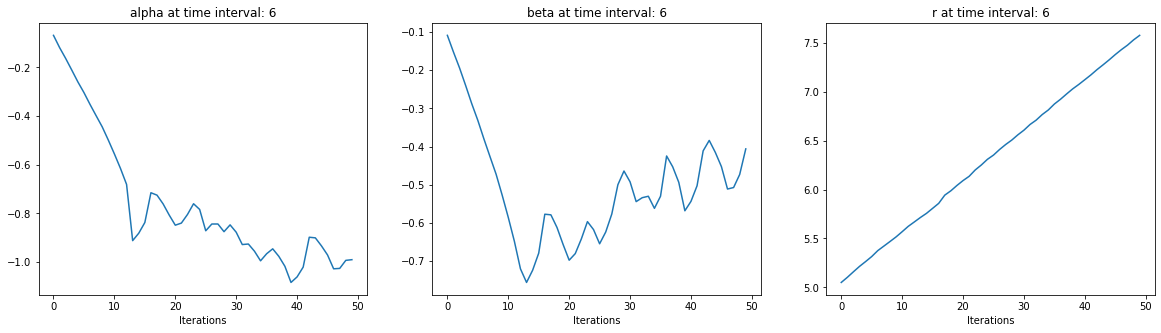

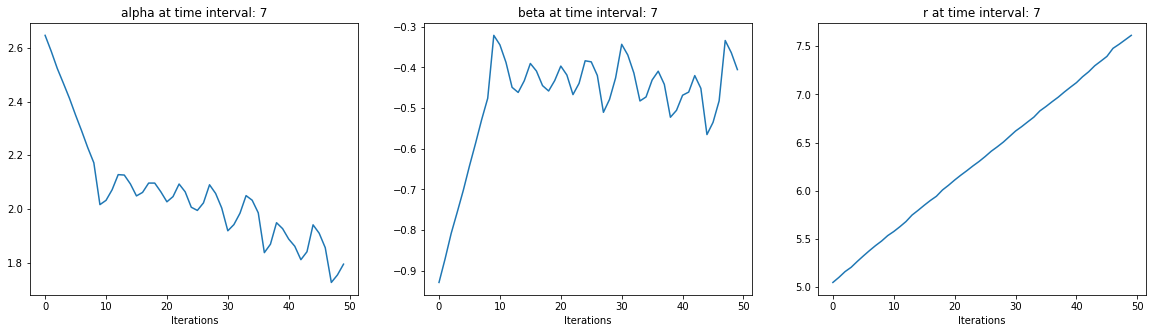

In [18]:
it_names = ['50']
par_names = ['alpha', 'beta', 'r']
for item, name in zip(output, it_names):
    vp__pts, vp__mean, vp__std, vp__pars = item[0], item[1], item[2], item[3]
    P, T, IT = len(par_names), obs_time.shape[0], 30

    for t in range(T-1):
        fig, ax = plt.subplots(nrows=1, ncols=P, figsize=(20, 5))
        for j, ax in enumerate(ax.ravel()):
            ax.plot(vp__pars[par_names[j]][t, :])
            ax.set_title(par_names[j] + " at time interval: %d" % t)
            ax.set_xlabel("Iterations")
        title = "Adam_" + "time_" + str(t) + "_iteration_" + name
#         plt.savefig("figures/" + title)
        plt.show()

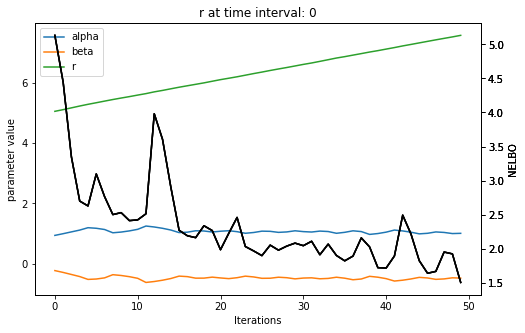

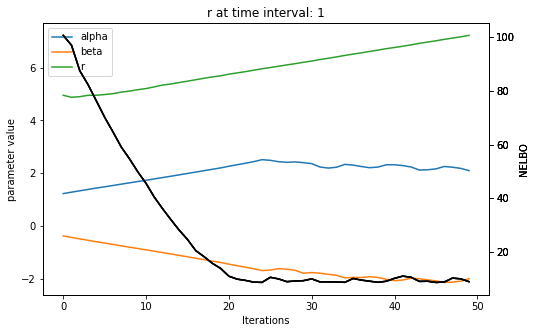

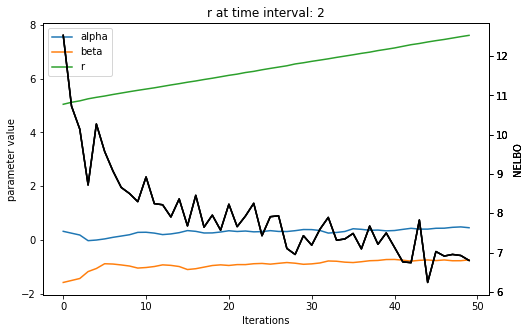

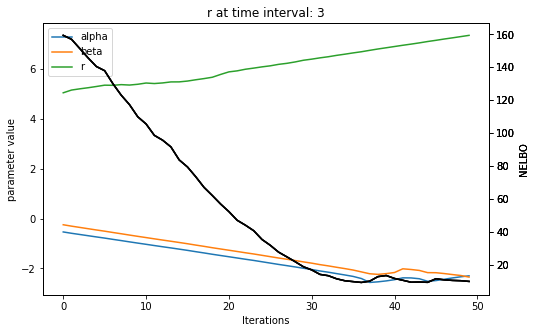

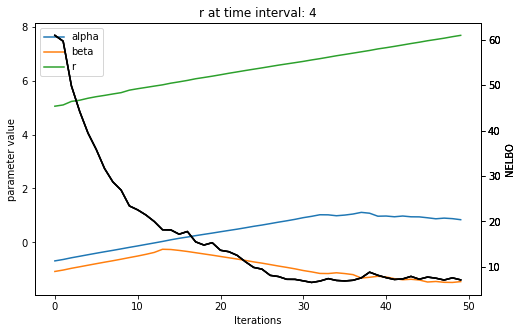

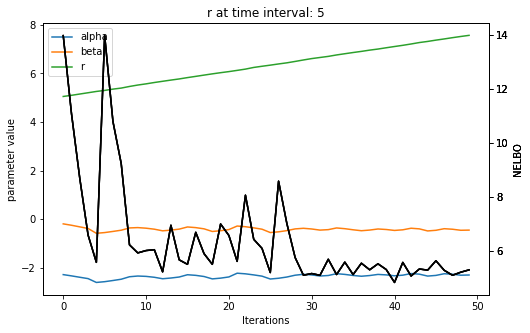

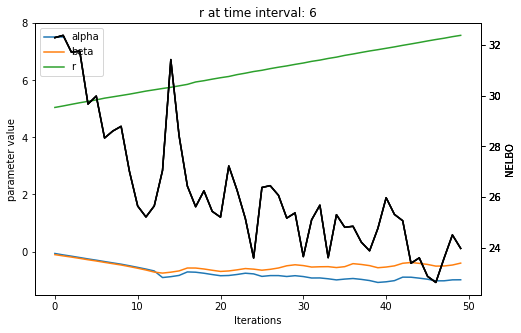

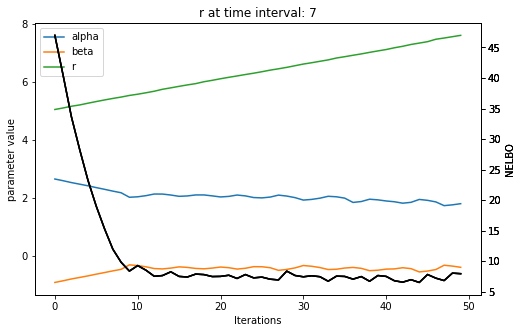

In [19]:
it_names = ['50']
par_names = ['alpha', 'beta', 'r']
for item, name in zip(output, it_names):
    vp__pts, vp__mean, vp__std, vp__pars = item[0], item[1], item[2], item[3]
    P, T, IT = len(par_names), obs_time.shape[0], 30

    for t in range(T-1):
        fig, ax1 = plt.subplots(figsize=(8, 5))
        for j in range(len(par_names)):
            ax1.plot(vp__pars[par_names[j]][t, :], label=par_names[j])
            ax1.set_title(par_names[j] + " at time interval: %d" % t)
            ax1.set_xlabel("Iterations")
            ax1.set_ylabel("parameter value")
            ax1.legend()
            ax2 = ax1.twinx()
            ax2.plot(vp__obj['NELBO'][t], label='Negative ELBO', color='black')
            ax2.set_ylabel("NELBO", color='black')
#             ax2.axhline(-20, linestyle='dashed', color='grey')
            
        title = "Adam_" + "time_" + str(t) + "_iteration_" + name
#         plt.savefig("figures/" + title)
        plt.show()

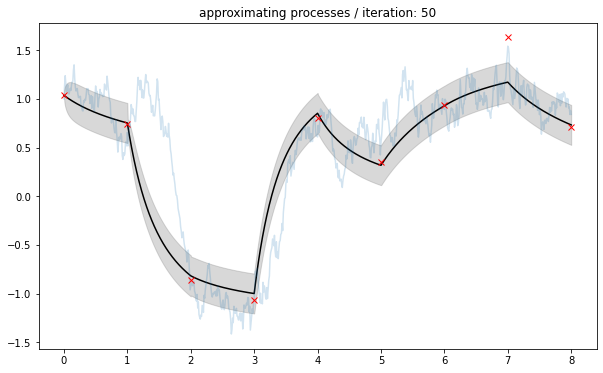

In [20]:
it_names = ['50']
for item, name in zip(output, it_names):
    vp__pts, vp__mean, vp__std, vp__pars = item[0], item[1], item[2], item[3]
    
    plt.figure(figsize=(10,6))
    plt.plot(vp__pts.T, vp__mean.T, color='black')
    plt.fill_between(vp__pts, vp__mean + vp__std, vp__mean - vp__std, alpha=0.3, color='grey')
    plt.plot(true_sde_pts, true_sde_trj, alpha=0.2)
    plt.plot(obs_time, obs, 'rx')
    title = "approximating processes / iteration: " + name
    plt.title(title)
    file_name = "Adam_" + "approx_process_" + "iteration_" + name
#     plt.savefig("figures/" + file_name)
    plt.show()

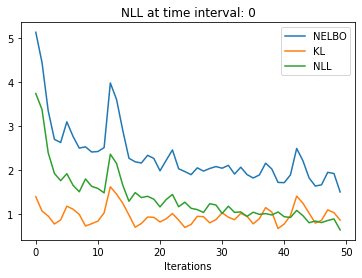

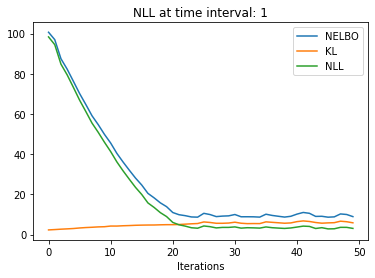

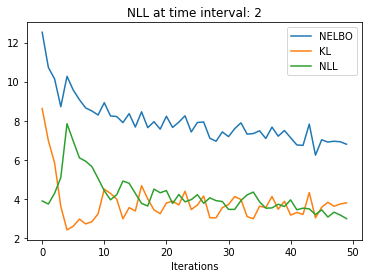

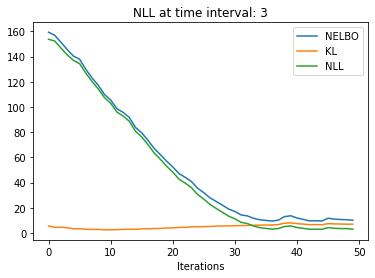

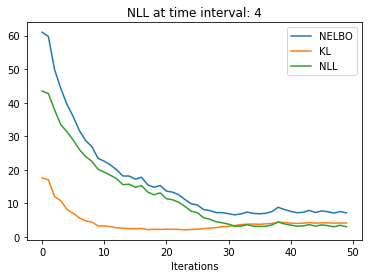

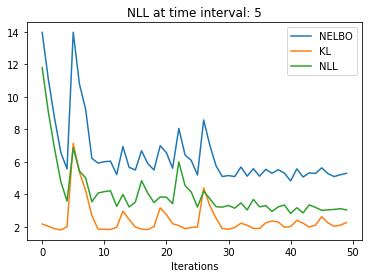

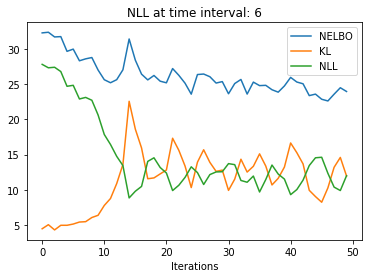

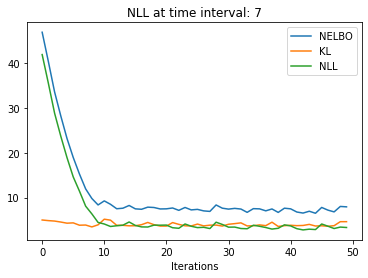

In [21]:
it_names = ['50']
obj_names = ['NELBO', 'KL', 'NLL']
for item, name in zip(output, it_names):
    P, T, IT = len(par_names), obs_time.shape[0], 30

    for t in range(T-1):
        plt.plot(figsize=(8, 6))
        for j in range(len(obj_names)):
            plt.plot(vp__obj[obj_names[j]][t], label=obj_names[j])
            plt.title(obj_names[j] + " at time interval: %d" % t)
            plt.xlabel("Iterations")
#             ax1.set_ylabel(obj_names[j])
            plt.legend()
            
        title = "Adam_" + "time_" + str(t) + "_iteration_" + name
#         plt.savefig("figures/" + title)
        plt.show()

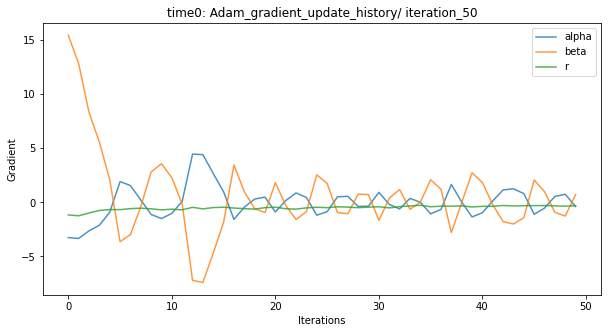

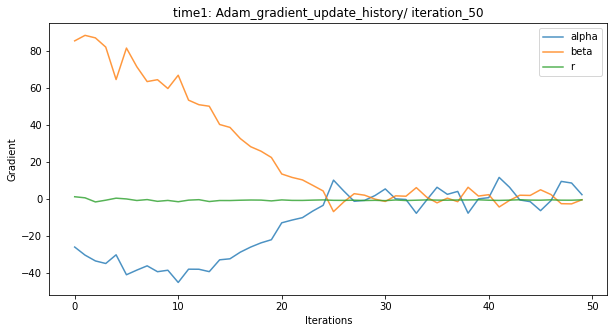

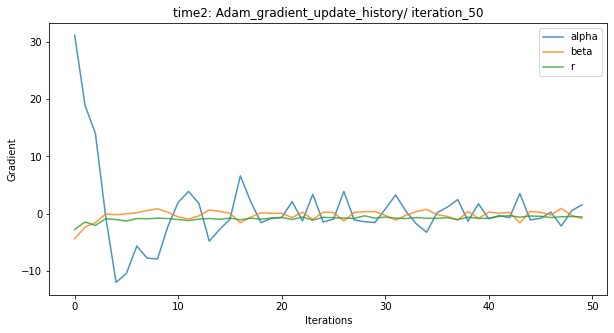

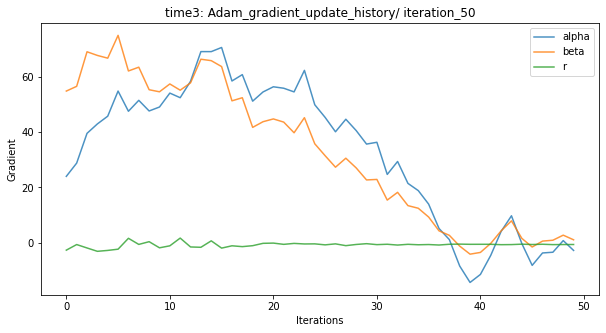

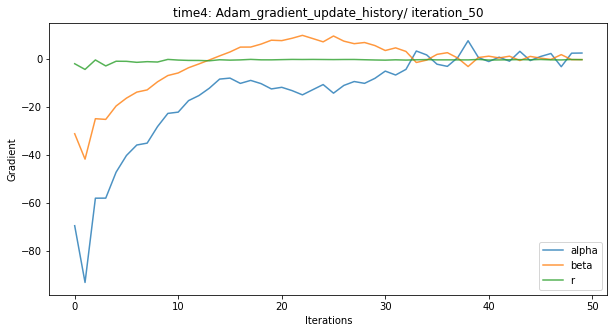

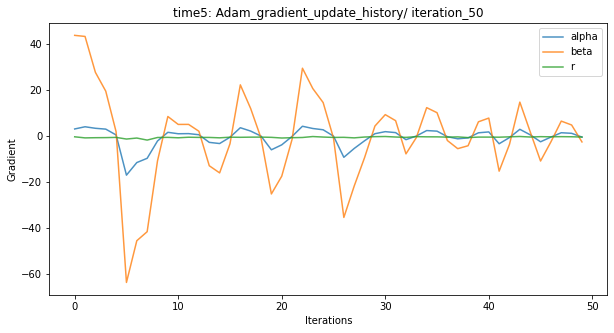

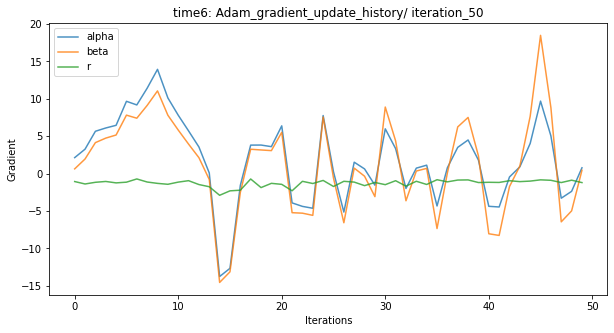

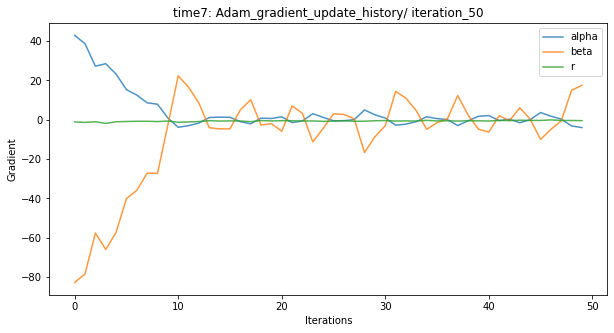

In [22]:
it_names = ['50']
for item, name in zip(output, it_names):
    vp_grads = item[4]
    for t in range(T-1):
        plt.figure(figsize=(10,5))

        for key in vp_grads.keys():
            plt.plot(vp_grads[key][t], label=key, alpha=0.8)
            plt.ylabel("Gradient")
            plt.xlabel("Iterations")
#             plt.axhline(np.mean(vp_grads[key][t]), linestyle='dashed', label=str(np.mean(vp_grads[key]).round(2)))
            plt.legend()

        file_name = "time" + str(t) + ": Adam_" + "gradient_update_history/ " + "iteration_" + name
        plt.title(file_name)
#     plt.savefig("figures/" + file_name)
    plt.show()

Fix $\alpha$ and optimize the other paramters, $\beta, r$

In [ ]:
fix_pars = {'alpha': torch.tensor(1.)}

In [ ]:
output = []
for it in tq.tqdm([50]):
    vp__pts, vp__mean, vp__std, vp__pars, vp__grads, vp__obj = Optimize(torch.tensor([sde_sigma]),\
                                                      obs, obs_time, obs_sigma, \
                                                      init_state="Random", M=1500, \
                                                      FIX_PAR = fix_pars,
                                                               \
                                                      IT=it, vN=150, learning_rate=0.05, \
                                                      Optimizer="Adam", beta_1 = 0.3, beta_2 = 0.01)
    output.append([vp__pts, vp__mean, vp__std, vp__pars, vp__grads])

In [ ]:
it_names = ['50']
par_names = ['alpha', 'beta', 'r']
for item, name in zip(output, it_names):
    vp__pts, vp__mean, vp__std, vp__pars = item[0], item[1], item[2], item[3]
    P, T, IT = len(par_names), obs_time.shape[0], 30

    for t in range(T-1):
        fig, ax1 = plt.subplots(figsize=(8, 5))
        for j in range(len(par_names)):
            ax1.plot(vp__pars[par_names[j]][t, :], label=par_names[j])
            ax1.set_title(par_names[j] + " at time interval: %d" % t)
            ax1.set_xlabel("Iterations")
            ax1.set_ylabel("parameter value")
            ax1.legend()
            ax2 = ax1.twinx()
            ax2.plot(-1 * vp__obj['ELBO'][t], label='ELBO', color='black')
            ax2.set_ylabel("ELBO", color='black')
#             ax2.axhline(-20, linestyle='dashed', color='grey')
            
        title = "Adam_" + "time_" + str(t) + "_iteration_" + name
#         plt.savefig("figures/" + title)
        plt.show()

In [ ]:
it_names = ['50']
for item, name in zip(output, it_names):
    vp__pts, vp__mean, vp__std, vp__pars = item[0], item[1], item[2], item[3]
    
    plt.figure(figsize=(10,6))
    plt.plot(vp__pts.T, vp__mean.T, color='black')
    plt.fill_between(vp__pts, vp__mean + vp__std, vp__mean - vp__std, alpha=0.3, color='grey')
    plt.plot(true_sde_pts, true_sde_trj, alpha=0.2)
    plt.plot(obs_time, obs, 'rx')
    title = "approximating processes / iteration: " + name
    plt.title(title)
    file_name = "Adam_" + "approx_process_" + "iteration_" + name
#     plt.savefig("figures/" + file_name)
    plt.show()

FIX $\beta$

In [ ]:
fix_pars = {'beta': torch.tensor(1.)}

In [ ]:
output = []
for it in tq.tqdm([50]):
    vp__pts, vp__mean, vp__std, vp__pars, vp__grads, vp__obj = Optimize(torch.tensor([sde_sigma]),\
                                                      obs, obs_time, obs_sigma, \
                                                      init_state="Random", M=1500, \
                                                      FIX_PAR = fix_pars,
                                                               \
                                                      IT=it, vN=150, learning_rate=0.05, \
                                                      Optimizer="Adam", beta_1 = 0.3, beta_2 = 0.01)
    output.append([vp__pts, vp__mean, vp__std, vp__pars, vp__grads])

In [ ]:
it_names = ['50']
par_names = ['alpha', 'beta', 'r']
for item, name in zip(output, it_names):
    vp__pts, vp__mean, vp__std, vp__pars = item[0], item[1], item[2], item[3]
    P, T, IT = len(par_names), obs_time.shape[0], 30

    for t in range(T-1):
        fig, ax1 = plt.subplots(figsize=(8, 5))
        for j in range(len(par_names)):
            ax1.plot(vp__pars[par_names[j]][t, :], label=par_names[j])
            ax1.set_title(par_names[j] + " at time interval: %d" % t)
            ax1.set_xlabel("Iterations")
            ax1.set_ylabel("parameter value")
            ax1.legend()
            ax2 = ax1.twinx()
            ax2.plot(-1 * vp__obj['ELBO'][t], label='ELBO', color='black')
            ax2.set_ylabel("ELBO", color='black')
#             ax2.axhline(-20, linestyle='dashed', color='grey')
            
        title = "Adam_" + "time_" + str(t) + "_iteration_" + name
#         plt.savefig("figures/" + title)
        plt.show()

In [ ]:
it_names = ['50']
for item, name in zip(output, it_names):
    vp__pts, vp__mean, vp__std, vp__pars = item[0], item[1], item[2], item[3]
    
    plt.figure(figsize=(10,6))
    plt.plot(vp__pts.T, vp__mean.T, color='black')
    plt.fill_between(vp__pts, vp__mean + vp__std, vp__mean - vp__std, alpha=0.3, color='grey')
    plt.plot(true_sde_pts, true_sde_trj, alpha=0.2)
    plt.plot(obs_time, obs, 'rx')
    title = "approximating processes / iteration: " + name
    plt.title(title)
    file_name = "Adam_" + "approx_process_" + "iteration_" + name
#     plt.savefig("figures/" + file_name)
    plt.show()

FIX $\alpha, \beta$

In [ ]:
fix_pars = {'beta': torch.tensor(1.), 'alpha':torch.tensor(2.)}

In [ ]:
output = []
for it in tq.tqdm([50]):
    vp__pts, vp__mean, vp__std, vp__pars, vp__grads, vp__obj = Optimize(torch.tensor([sde_sigma]),\
                                                      obs, obs_time, obs_sigma, \
                                                      init_state="Random", M=1500, \
                                                      FIX_PAR = fix_pars,
                                                               \
                                                      IT=it, vN=150, learning_rate=0.05, \
                                                      Optimizer="Adam", beta_1 = 0.1, beta_2 = 0.01)
    output.append([vp__pts, vp__mean, vp__std, vp__pars, vp__grads])

In [ ]:
it_names = ['50']
par_names = ['alpha', 'beta', 'r']
for item, name in zip(output, it_names):
    vp__pts, vp__mean, vp__std, vp__pars = item[0], item[1], item[2], item[3]
    P, T, IT = len(par_names), obs_time.shape[0], 30

    for t in range(T-1):
        fig, ax1 = plt.subplots(figsize=(8, 5))
        for j in range(len(par_names)):
            ax1.plot(vp__pars[par_names[j]][t, :], label=par_names[j])
            ax1.set_title(par_names[j] + " at time interval: %d" % t)
            ax1.set_xlabel("Iterations")
            ax1.set_ylabel("parameter value")
            ax1.legend()
            ax2 = ax1.twinx()
            ax2.plot(-1 * vp__obj['ELBO'][t], label='ELBO', color='black')
            ax2.set_ylabel("ELBO", color='black')
#             ax2.axhline(-20, linestyle='dashed', color='grey')
            
        title = "Adam_" + "time_" + str(t) + "_iteration_" + name
#         plt.savefig("figures/" + title)
        plt.show()

In [ ]:
it_names = ['50']
for item, name in zip(output, it_names):
    vp__pts, vp__mean, vp__std, vp__pars = item[0], item[1], item[2], item[3]
    
    plt.figure(figsize=(10,6))
    plt.plot(vp__pts.T, vp__mean.T, color='black')
    plt.fill_between(vp__pts, vp__mean + vp__std, vp__mean - vp__std, alpha=0.3, color='grey')
    plt.plot(true_sde_pts, true_sde_trj, alpha=0.2)
    plt.plot(obs_time, obs, 'rx')
    title = "approximating processes / iteration: " + name
    plt.title(title)
    file_name = "Adam_" + "approx_process_" + "iteration_" + name
#     plt.savefig("figures/" + file_name)
    plt.show()

what if we reduce the time step by factor of 50?

In [ ]:
output = []
for it in tq.tqdm([50]):
    vp__pts, vp__mean, vp__std, vp__pars, vp__grads, vp__obj = Optimize(torch.tensor([sde_sigma]),\
                                                      obs, obs_time/50, obs_sigma, \
                                                      init_state="Random", M=1500, \
#                                                       FIX_PAR = fix_pars,
#                                                                \
                                                      IT=it, vN=150, learning_rate=0.15, \
                                                      Optimizer="Adam", beta_1 = 0.5, beta_2 = 0.01)
    output.append([vp__pts, vp__mean, vp__std, vp__pars, vp__grads])

In [ ]:
it_names = ['50']
par_names = ['alpha', 'beta', 'r']
for item, name in zip(output, it_names):
    vp__pts, vp__mean, vp__std, vp__pars = item[0], item[1], item[2], item[3]
    P, T, IT = len(par_names), obs_time.shape[0], 30

    for t in range(T-1):
        fig, ax1 = plt.subplots(figsize=(8, 5))
        for j in range(len(par_names)):
            ax1.plot(vp__pars[par_names[j]][t, :], label=par_names[j])
            ax1.set_title(par_names[j] + " at time interval: %d" % t)
            ax1.set_xlabel("Iterations")
            ax1.set_ylabel("parameter value")
            ax1.legend()
            ax2 = ax1.twinx()
            ax2.plot(-1 * vp__obj['ELBO'][t], label='ELBO', color='black')
            ax2.set_ylabel("ELBO", color='black')
#             ax2.axhline(-20, linestyle='dashed', color='grey')
            
        title = "Adam_" + "time_" + str(t) + "_iteration_" + name
#         plt.savefig("figures/" + title)
        plt.show()

In [ ]:
it_names = ['50']
for item, name in zip(output, it_names):
    vp__pts, vp__mean, vp__std, vp__pars = item[0], item[1], item[2], item[3]
    
    plt.figure(figsize=(10,6))
    plt.plot(vp__pts.T, vp__mean.T, color='black')
    plt.fill_between(vp__pts, vp__mean + vp__std, vp__mean - vp__std, alpha=0.3, color='grey')
    plt.plot(true_sde_pts/50, true_sde_trj, alpha=0.2)
    plt.plot(obs_time/50, obs, 'rx')
    title = "approximating processes / iteration: " + name
    plt.title(title)
    file_name = "Adam_" + "approx_process_" + "iteration_" + name
#     plt.savefig("figures/" + file_name)
    plt.show()

In [ ]:
it_names = ['50']
obj_names = ['ELBO', 'KL', 'NLL']
for item, name in zip(output, it_names):
    P, T, IT = len(par_names), obs_time.shape[0], 30

    for t in range(T-1):
        plt.plot(figsize=(8, 6))
        for j in range(len(obj_names)):
            plt.plot(vp__obj[obj_names[j]][t], label=obj_names[j])
            plt.title(obj_names[j] + " at time interval: %d" % t)
            plt.xlabel("Iterations")
#             ax1.set_ylabel(obj_names[j])
            plt.legend()
            
        title = "Adam_" + "time_" + str(t) + "_iteration_" + name
#         plt.savefig("figures/" + title)
        plt.show()